In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import pandas as pd
import photutils

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from photutils.detection import DAOStarFinder
from photutils.morphology import data_properties
from astropy.stats import mad_std

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse
from sklearn.model_selection import train_test_split



In [2]:
"""
#load the image arrays 

blends = np.load("C:\\Datasets\\central_blends.npy")
components = np.load("C:\\Datasets\\central_components.npy")
"""

'\n#load the image arrays \n\nblends = np.load("C:\\Datasets\\central_blends.npy")\ncomponents = np.load("C:\\Datasets\\central_components.npy")\n'

In [3]:

#load the image arrays 

blends = np.load("blends.npy")
components = np.load("Components.npy")


In [4]:

#Normalise the data

blends_max = np.amax(blends)
blends_min = np.amin(blends)

blends -= blends_min
blends /= blends_max

components_max = np.amax(components) 
components_min = np.amin(components)

components -= components_min
components /= components_max 



In [5]:
height,width=64,64

n_gals = blends.shape[0] 

blends = blends.reshape(n_gals, height, width, 1).astype('float32')
components= components.reshape(2,n_gals,height,width,1).astype('float32')


In [6]:
batch_size = 32
latent_dimensions = 16

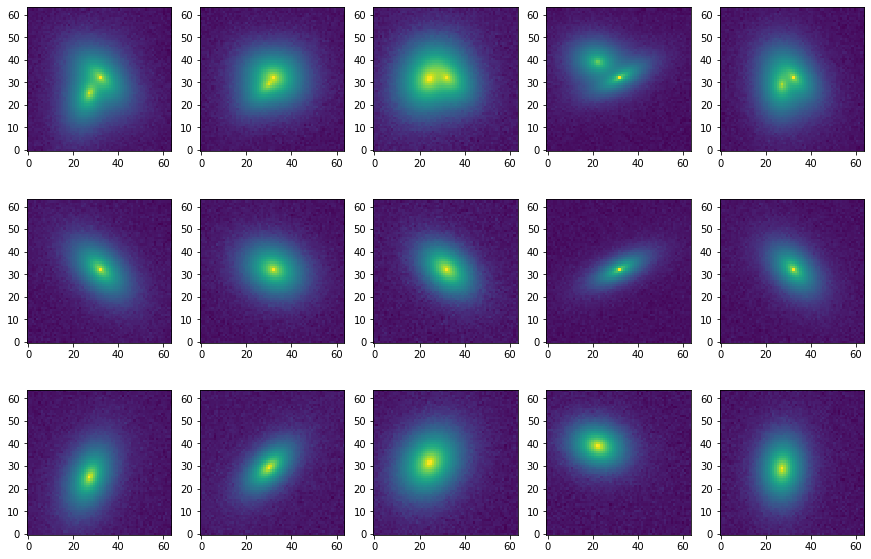

In [7]:
fig, ax = plt.subplots(2 + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(blends[i], origin='lower', interpolation='nearest')
    ax[1, i].imshow(components[0, i], origin='lower', interpolation='nearest')
    ax[2, i].imshow(components[1, i], origin='lower', interpolation='nearest')

In [8]:
#Will optimise encoder / decoder later
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    return x

In [9]:
def decoder(x):
    #x=UpSampling2D()(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [10]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [11]:
# encoder
input_blend=Input(shape=(height, width,1))

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

In [12]:
# decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

embed2=Dense(np.prod(shape),activation='relu')(input_embed)
embed2=Reshape(shape)(embed2)
decoded2=decoder(embed2)
output2=Conv2DTranspose(1,3,padding='same')(decoded2)

In [13]:
encode=Model(input_blend,z)
encode.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d_1[0][0]']               
                                                                                              

In [14]:
input_component1 = Input(shape=(height, width, 1))
input_component2 = Input(shape=(height, width, 1))

decode=Model([input_embed, input_component1, input_component2], [output1, output2])
decode.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 1024)         17408       ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 1024)         17408       ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 4, 4, 64)     0           ['dense_2[0][0]']                
                                                                                            

In [15]:
encoding = encode(input_blend)
re1, re2 = decode([encoding, input_component1, input_component2])

vae = Model([input_blend, input_component1, input_component2], [re1, re2])

In [16]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 16)           97792       ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                            

In [17]:
blends.shape, components.shape 

((3000, 64, 64, 1), (2, 3000, 64, 64, 1))

In [18]:
mse_lossA = mse(input_component1, re1) + mse(input_component2, re2)
mse_lossA = tf.reduce_mean(mse_lossA / 2, axis=(1, 2))
mse_lossB = mse(input_component1, re2) + mse(input_component2, re1)
mse_lossB = tf.reduce_mean(mse_lossB / 2, axis=(1, 2))
mse_loss = tf.reduce_mean(tf.minimum(mse_lossA, mse_lossB)) * height * width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss, 'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*0.1
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')


together = [blends, components[0], components[1]]
vae.compile(optimizer=Adam())

In [62]:
history=vae.fit(together, verbose = 1, epochs = 50, batch_size = batch_size, validation_split = 0.2)

Epoch 1/2
75/75 [==============================] - 20s 266ms/step - loss: 10.1175 - mse_loss: 9.9001 - kl_loss: 0.2174 - val_loss: 8.5025 - val_mse_loss: 8.2426 - val_kl_loss: 0.2599
Epoch 2/2
75/75 [==============================] - 21s 278ms/step - loss: 7.3618 - mse_loss: 7.1127 - kl_loss: 0.2491 - val_loss: 6.8112 - val_mse_loss: 6.5753 - val_kl_loss: 0.2359


In [87]:
def histplot(history):
    fig = plt.figure( )
    plt.rcParams["figure.figsize"] = (10,7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.axhline( y = min(val_loss), color = 'black', linestyle = 'dotted', label = 'Minimum Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    fig.savefig('Model Loss hist.png')

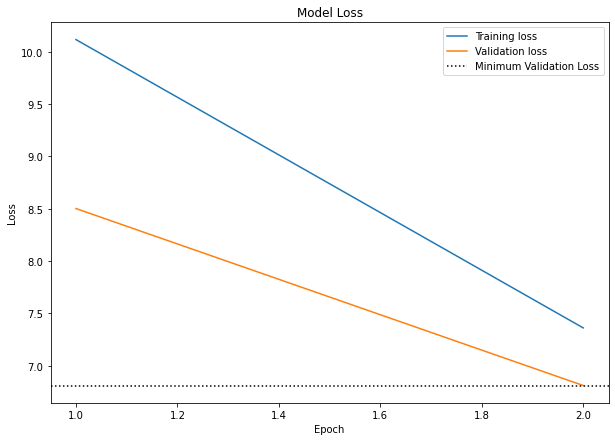

In [88]:
histplot(history)

In [21]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    fig, ax = plt.subplots(6, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(input_img[i], origin='lower', interpolation='nearest')
        ax[0, i].set_title('Input Blend')
        ax[1, i].imshow(comp1[i], origin='lower', interpolation='nearest')
        ax[1, i].set_title('Input Component 1')
        ax[2, i].imshow(comp2[i], origin='lower', interpolation='nearest')
        ax[2, i].set_title('Input Component 2')
        ax[3, i].imshow(output_img1[i], origin='lower', interpolation='nearest')
        ax[3, i].set_title('Reconstruction Component 1')
        ax[3, i].set_xlabel(f'MSE: {mean_squared_error(comp1[i], output_img1[i]):.2f}, SSIM: {ssim(comp1[i], output_img1[i], channel_axis = 2):.2f}')
        ax[4, i].imshow(output_img2[i], origin='lower', interpolation='nearest')
        ax[4, i].set_title('Reconstruction Component 2')
        ax[4, i].set_xlabel(f'MSE: {mean_squared_error(comp2[i], output_img2[i]):.2f}, SSIM: {ssim(comp2[i], output_img2[i], channel_axis = 2):.2f}')
        ax[5, i].imshow(-1*abs(input_img[i] -(output_img1[i] + output_img2[i])) , origin='lower', interpolation='nearest')
        ax[5, i].set_title('Blend Difference')
        plt.tight_layout()
    plt.savefig('Summary plot.png')
    return idx

[1957 2087 1394 1520 1098]


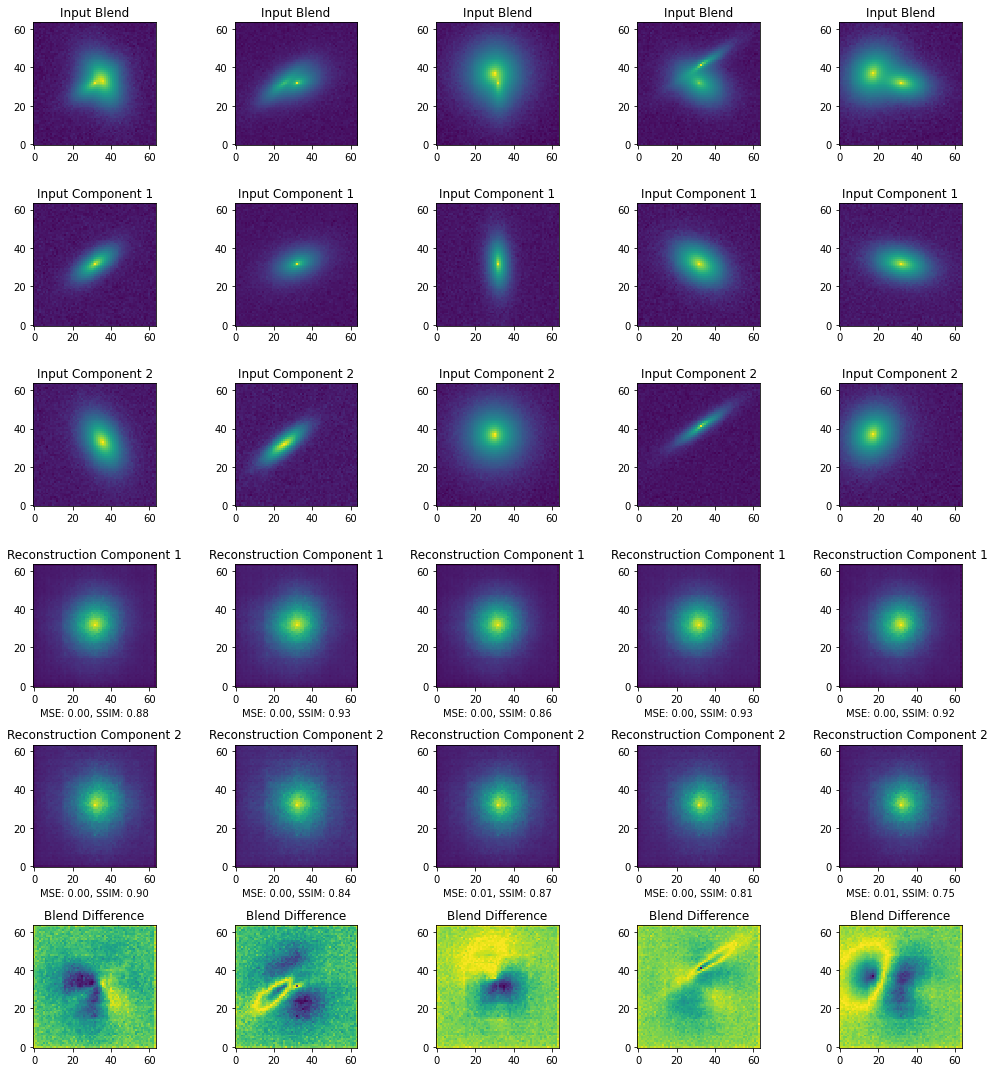

In [22]:
n=5
chosen=summary_plot(n,together,decode)

In [52]:
def calc_ssim(inputs,decode):
    ssim_comp1 = np.zeros(n_gals)
    ssim_comp2 = ssim_comp1
    ssim_blends = ssim_comp1
    input_img = inputs[0]
    comp1 = inputs[1]
    comp2 = inputs[2]
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    for i in range(n_gals):
        ssim_comp1[i] = ssim(comp1[i], output_img1[i], channel_axis = 2)
        ssim_comp2[i] = ssim(comp2[i], output_img2[i], channel_axis = 2)
        ssim_blends[i] = ssim(input_img[i], (output_img1[i] + output_img2[i]), channel_axis = 2)
        
    mean_ssim_comp1 = np.mean(ssim_comp1)
    median_ssim_comp1 = np.median(ssim_comp1)
    
    mean_ssim_comp2 = np.mean(ssim_comp2)
    median_ssim_comp2 = np.median(ssim_comp2)
    
    mean_ssim_blends = np.mean(ssim_blends)
    median_ssim_blends = np.median(ssim_blends)
    
    ssim_values = np.array([mean_ssim_comp1, median_ssim_comp1, mean_ssim_comp2, median_ssim_comp2, mean_ssim_blends, median_ssim_blends])  
    
    return ssim_values
        
        
        

    
    

In [53]:
ssim_values = calc_ssim(together, decode)

[0.76998825 0.77864763 0.76998825 0.77864763 0.76998825 0.77864763]


In [54]:
np.save("ssim_values.npy", ssim_values)

In [57]:
#This function calculates the properties of the input and output images. The ellipticity and flux are stored in arrays 

def calc_properties(inputs,decode):
    
    empty_array = np.zeros(n_gals)
    
    flux_in_comp1 = np.zeros(n_gals)
    flux_in_comp2 = np.zeros(n_gals)
    flux_in_blends = np.zeros(n_gals)
    
    flux_out_comp1 = np.zeros(n_gals)
    flux_out_comp2 = np.zeros(n_gals)
    flux_out_blends = np.zeros(n_gals)
    
    
    elip_in_comp1 = np.zeros(n_gals)
    elip_in_comp2 = np.zeros(n_gals)
    
    elip_out_comp1 = np.zeros(n_gals)
    elip_out_comp2 = np.zeros(n_gals)
    
    input_img = inputs[0]
    input_img = input_img.reshape(n_gals, height, width)
    comp1 = inputs[1]
    comp1 = comp1.reshape(n_gals, height, width)
    comp2 = inputs[2]
    comp2 = comp2.reshape(n_gals, height,width)
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    
    output_img1 = output_img1.reshape(n_gals, height, width)
    output_img2 = output_img2.reshape(n_gals, height, width)
    
    for i in range(n_gals):
        
        in_comp1_cat = photutils.morphology.data_properties(comp1[i], mask = None, background = 0)
        elip_in_comp1[i] = in_comp1_cat.ellipticity
        flux_in_comp1[i] = in_comp1_cat.segment_flux
        
        in_comp2_cat = photutils.morphology.data_properties(comp2[i], mask = None, background = 0)
  
        elip_in_comp2[i] = in_comp2_cat.ellipticity
        flux_in_comp2[i] = in_comp2_cat.segment_flux
        
        in_blends_cat = photutils.morphology.data_properties(input_img[i], mask = None, background = 0)
        flux_in_blends[i] = in_blends_cat.segment_flux

            
        out_comp1_cat = photutils.morphology.data_properties(output_img1[i], mask = None, background = 0)
        elip_out_comp1[i] = out_comp1_cat.ellipticity
        flux_out_comp1[i] = out_comp1_cat.segment_flux
        
        out_comp2_cat = photutils.morphology.data_properties(output_img2[i], mask = None, background = 0)
        elip_out_comp2[i] = out_comp2_cat.ellipticity
        flux_out_comp2[i] = out_comp2_cat.segment_flux
        
        out_blends_cat = photutils.morphology.data_properties((output_img1[i] + output_img2[i]), mask = None, background = 0)
        flux_out_blends[i] = out_blends_cat.segment_flux
        
        parameters = np.array([elip_in_comp1, elip_out_comp1, flux_in_comp1, flux_out_comp1, elip_in_comp2, elip_out_comp2, flux_in_comp2, flux_out_comp2, flux_in_blends, flux_out_blends])   
    return parameters


        

In [58]:
parameters = calc_properties(together, decode)

np.save("parameters.npy", parameters)